# Working session S2024

This notebook contains some examples and is a work in progress: code will transition from here to other notebooks. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import dateutil

from Exploring_Argo_BGC_with_Argovis_helpers import interpolate
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

/Users/dgiglio/opt/miniconda3/envs/argovis_demos/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# get doxy profiles in a region and time period of interest

variable             = 'doxy' # variable name in Argo profiles
variable_gridded     = 'oxygen' # variable name in glodap gridded product
product_gridded      = 'glodap'
variable_title       = 'Oxygen, umol/kg'

# variable             = 'temperature' # variable name in Argo profiles
# variable_gridded     = 'rg09_temperature' # variable name in glodap gridded product
# product_gridded      = 'rg09'
# variable_title       = 'Temperature, degC'

variable             = 'salinity' # variable name in Argo profiles
variable_gridded     = 'rg09_salinity' # variable name in glodap gridded product
product_gridded      = 'rg09'
variable_title       = 'Salinity, psu'

# levels for vertically integrated profiles
interp_levels        = list(range(10,2001))[0::20]

# in this example, we will use the 'box' selection (in the next cell),
# hence we indicate here the bottom/left and top/right vertices... 
# the other option is to search in a 'polygon' and indicate here the polygon
# vertices in a list
box_regions_list     = [
                        [[-35.5,48.5],[-32.5,50.5]],
    
                        ]
box_regions_list     = [
                        [[-275.6309525143811,19.12926798389727],[-265.28643702838974,18.918199016792155],[-265.5841209272672,23.768490101412514],[-275.8542154385392,23.83658095706345],[-275.6309525143811,19.12926798389727]],
                        ]

startDate            = '2000-01-01T00:00:00Z'
endDate              = '2024-03-31T00:00:00Z'

# box_regions_list     = [
#                         [[-78,45],[-10,50]],
#                         [[-180,45],[-127,50]],
#                         ]

Mon Apr  1 09:56:21 PDT 2024
Mon Apr  1 09:57:08 PDT 2024


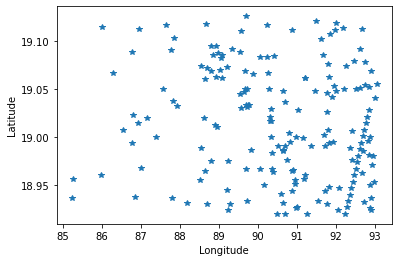

In [3]:
!date

regions_list_data                 = []
regions_list_data_noave           = []
regions_list_data_levels          = []
regions_list_data_time            = []
regions_list_data_noave_nointerp  = []
regions_list_data_grid_axarray    = []
############ Get the data for each of the regions of interest
for ireg in box_regions_list:
    ###### get profiles in region using Argovis API: query only values with QC = 1
    argo = {
            'startDate': startDate,
            'endDate': endDate,
            'box': ireg,
            'data': variable+',1'
            } # querying only profiles that have good qc doxy 
            # 'polygon': ireg,

    profiles = avh.query('argo', options=argo, apikey=API_KEY, apiroot=API_ROOT) 
    
    ###### store data as is and interpolated
    if len(profiles)>0:
        ## interpolate profiles   
        interpolated_profiles      = []
        interpolated_profiles_time = []
        interpolated_profiles_lon  = []
        interpolated_profiles_lat  = []
        for i in list(range(0,len(profiles)-1)):
            if len(profiles[i]['data'][0]) > 1:
                interpolated_profiles.append(interpolate(profiles[i],interp_levels))
                interpolated_profiles_time.append(dateutil.parser.isoparse(profiles[i]['timestamp'])) 
                interpolated_profiles_lon.append(profiles[i]['geolocation']['coordinates'][0])
                interpolated_profiles_lat.append(profiles[i]['geolocation']['coordinates'][1])
        # shape variable into something appropriate
        data = [x['data'] for x in interpolated_profiles]
        data = [[level[variable] for level in x] for x in data]

        ## store profile data
        regions_list_data_noave.append(data)
        regions_list_data_noave_nointerp.append([x['data'] for x in profiles])
        data = np.transpose(data)
        regions_list_data.append(np.nanmean(data,1))
        regions_list_data_levels.append(interp_levels)
        regions_list_data_time.append(interpolated_profiles_time)

        ## quick plot of profiles in region
        plt.figure()
        plt.plot(interpolated_profiles_lon,interpolated_profiles_lat,marker='*',linestyle='none')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
    
!date    

In [9]:
!date
####### do the same for gridded data
for ireg in box_regions_list:
    # get grid points in a region using the Argovis API
    grids_opt = {
            'box': ireg,
            'data': variable_gridded
            } # querying only profiles that have good qc doxy

    grids = avh.query('grids/'+product_gridded, options=grids_opt, apikey=API_KEY, apiroot=API_ROOT)
    
    if not grids:
        print('No grid points in the region of interest')
    else:
        grids_opt  = {
                        "id": grids[0]['metadata'][0]
                        }
        grids_meta = avh.query('grids/meta', options=grids_opt, apikey=API_KEY, apiroot=API_ROOT)
        !date

        if 'glodap' in product_gridded:
            xar = helpers.grids_to_xarray(grids,grids_meta)
        elif 'rg09' in product_gridded:
            df = helpers.level_df(grids, 
                [variable_gridded, 'longitude', 'latitude', 'timestamp'], 
                per_level_pressures=grids_meta[0]['levels'], 
                index=["latitude","longitude","timestamp","pressure"]
                )
            df = df.rename(columns={variable_gridded: "data"})
            xar = df.to_xarray()
            # time mean
            xar = xar.mean(dim='timestamp')
        else:
            to_complete

        # store data
        regions_list_data_grid_axarray.append(xar)
        regions_list_data.append(helpers.regional_mean(xar)['data'].values.flatten())
        regions_list_data_levels.append(grids_meta[0]['levels'])
        grids_meta
!date        


Mon Apr  1 09:59:38 PDT 2024
No grid points in the region of interest
Mon Apr  1 09:59:41 PDT 2024


In [10]:
# plot the map for one timestep/level for each of the gridded products
for iaxr in regions_list_data_grid_axarray:
    plt.figure()
    iaxr['data'][:,:,0].plot()

In [11]:
cols = ['k','r','b','m']

Text(0.5, 0, 'Salinity, psu')

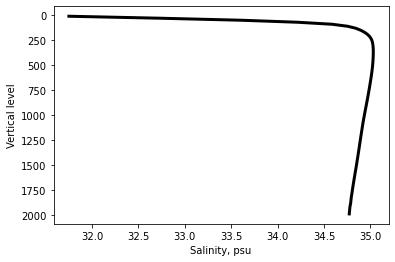

In [12]:
# plot the horizontal average for (vertically) interpolated profiles and for the gridded product
for i,idata in enumerate(regions_list_data):
    plt.plot(idata,regions_list_data_levels[i],color=cols[i],linewidth=3)
plt.gca().invert_yaxis()
plt.ylabel('Vertical level')
plt.xlabel(variable_title)

Text(0.5, 0, 'Salinity, psu')

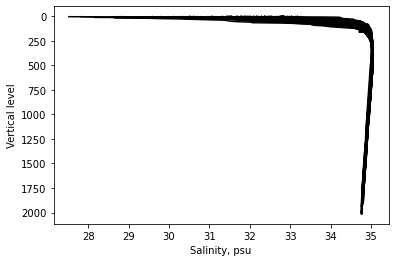

In [13]:
# plot raw profiles that go into the average
for i,idata in enumerate(regions_list_data_noave_nointerp):
    for iidata in idata:
        
        plt.plot(iidata[0],iidata[1],color=cols[i]) #,marker='.'
        
        # check for oxygen data
        if ('doxy' in variable) and sum(np.array(iidata[0])<0) != 0:
            check_data
#plt.ylim([0, 20])
plt.gca().invert_yaxis()        
plt.ylabel('Vertical level')
plt.xlabel(variable_title)


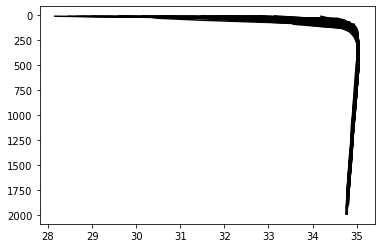

In [14]:
# plot vertically integrated profiles that go into the average
for i,idata in enumerate(regions_list_data_noave):
    for ii,iidata in enumerate(idata):
        
        plt.plot(iidata,regions_list_data_levels[i],color=cols[i])
        if sum(np.array(iidata)<0) != 0:
            ciao
plt.gca().invert_yaxis()

Text(0.5, 0, 'Salinity, psu')

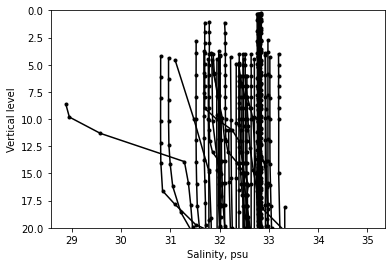

In [15]:
#regions_list_data_time_month = [x.month for y in regions_list_data_time for x in y]
# plot raw profiles that go into the average colorcoded by month of year
for i,idata in enumerate(regions_list_data_noave_nointerp):
    itime = regions_list_data_time[i]
    for ii,iidata in enumerate(idata):
        
        if ii<=len(itime)-1 and itime[ii].month in [6, 7, 8]:
            plt.plot(iidata[0],iidata[1],c='k',marker='.')
            
        # check for oxygen data
        if ('doxy' in variable) and sum(np.array(iidata[0])<0) != 0:
            check_data
plt.ylim([0, 20])
plt.gca().invert_yaxis()        
plt.ylabel('Vertical level')
plt.xlabel(variable_title)